# Notes
* original dataset: https://www.kaggle.com/competitions/fake-news/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
%matplotlib inline


import os
import pickle

# timing utilities
from timeit import default_timer as timer
from datetime import timedelta


In [3]:
input_path = "./data/"
output_path = "./models/"

submit = pd.read_csv(input_path + "submit.csv") # sample labels; I think it's just to show format of output for test predictions
test = pd.read_csv(input_path + "test.csv")
train = pd.read_csv(input_path + "train.csv")

# labels

## Data preprocessing

In [4]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# only run to download resources; can specify download directory with argument `download_dir`
# import nltk
# nltk.download("wordnet")
# nltk.download("stopwords")

In [5]:
def clean_text(df, text, stop_words=True, lemmatize=True):
    """Clean text column of a dataframe.
    
    Remove special characters and stop words. Lemmatize words to common root.
    
    Args:
        df (DataFrame) : Dataframe with a text column to clean.
        text (str) : Name of text column in `df`.
        stop_words (bool, default True) : If True, remove English stopwords ("the", "an", etc.).
        lemmatize (bool, default True) : If True, lemmatize words to common root.
    
    Returns:
        (DataFrame) : The original `df` with `text` column replaced with cleaned text.
    """
    
    # basic error handling
    df = df.drop_duplicates()
    df = df.dropna(subset=[text])
    
    # elminating weird characters
    # edited to also drop numbers for BERT
    df[text] = df[text].str.replace(r'[^a-zA-Z]', ' ', regex=True)
    df[text] = df[text].str.lower()
    df = df.dropna(subset=[text])
    
    tokens = df[text].str.split()
    
    if stop_words:
        sw = stopwords.words("english")
        tokens = tokens.apply(lambda row_words: [word for word in row_words if sw.count(word)==0])
    
    if lemmatize:
#         stemmer = PorterStemmer()
#         tokens = tokens.apply(lambda row_words: [stemmer.stem(word) for word in row_words])
        lemmatizer = WordNetLemmatizer()
        tokens = tokens.apply(lambda row_words: [lemmatizer.lemmatize(word) for word in row_words])
    
    tokens = tokens.apply(lambda row_words: ' '.join(row_words))

    df[text] = tokens
    
    return df

In [6]:
train_clean = clean_text(train, "text", stop_words=False, lemmatize=False)

In [7]:
train_clean.text.head(10)

0    house dem aide we didn t even see comey s lett...
1    ever get the feeling your life circles the rou...
2    why the truth might get you fired october the ...
3    videos civilians killed in single us airstrike...
4    print an iranian woman has been sentenced to s...
5    in these trying times jackie mason is the voic...
6    ever wonder how britain s most iconic pop pian...
7    paris france chose an idealistic traditional c...
8    donald j trump is scheduled to make a highly a...
9    a week before michael t flynn resigned as nati...
Name: text, dtype: object

## Word Cloud to view contents

In [8]:
from wordcloud import WordCloud

real_text = train_clean.loc[train_clean.label==0, "text"]
real_text = " ".join([article for article in real_text.astype(str)])

fake_text = train_clean.loc[train_clean.label==1, "text"]
fake_text = " ".join([article for article in fake_text.astype(str)])

Word Cloud of Real Articles

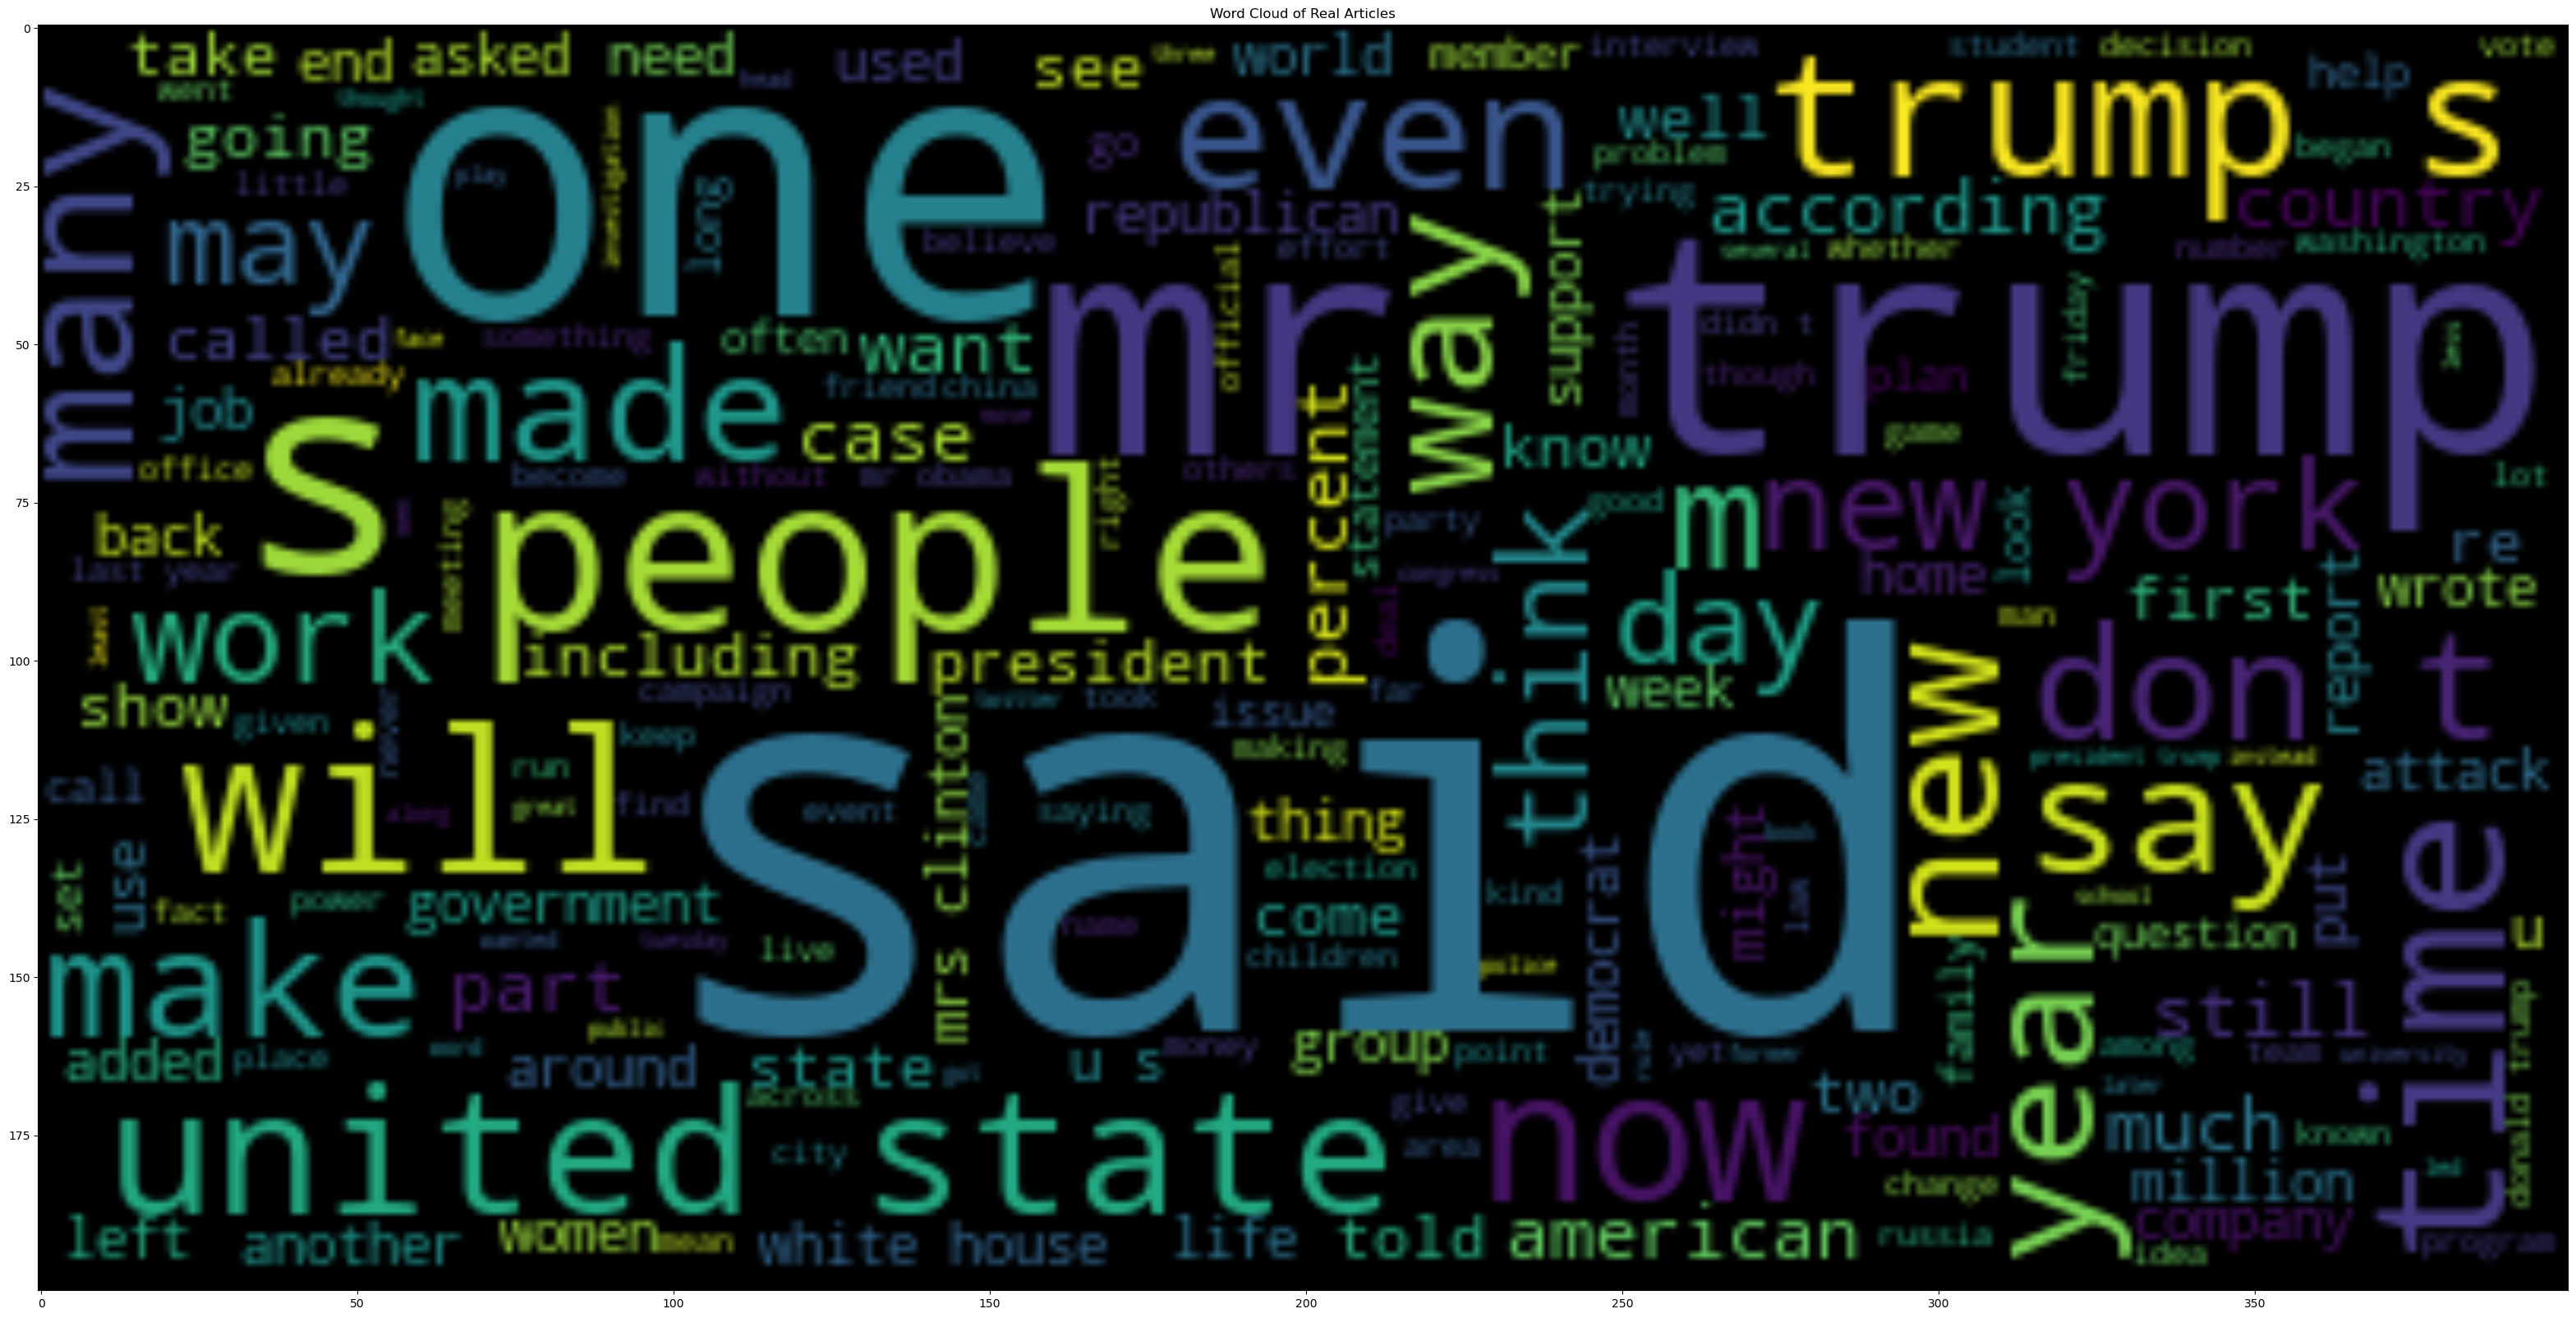

In [9]:
real_wc = WordCloud().generate(real_text)
plt.figure(figsize=(40, 20))
plt.tight_layout(pad=0)
plt.imshow(real_wc, interpolation='bilinear')
plt.title("Word Cloud of Real Articles")
plt.show()

Word Cloud of Fake Articles

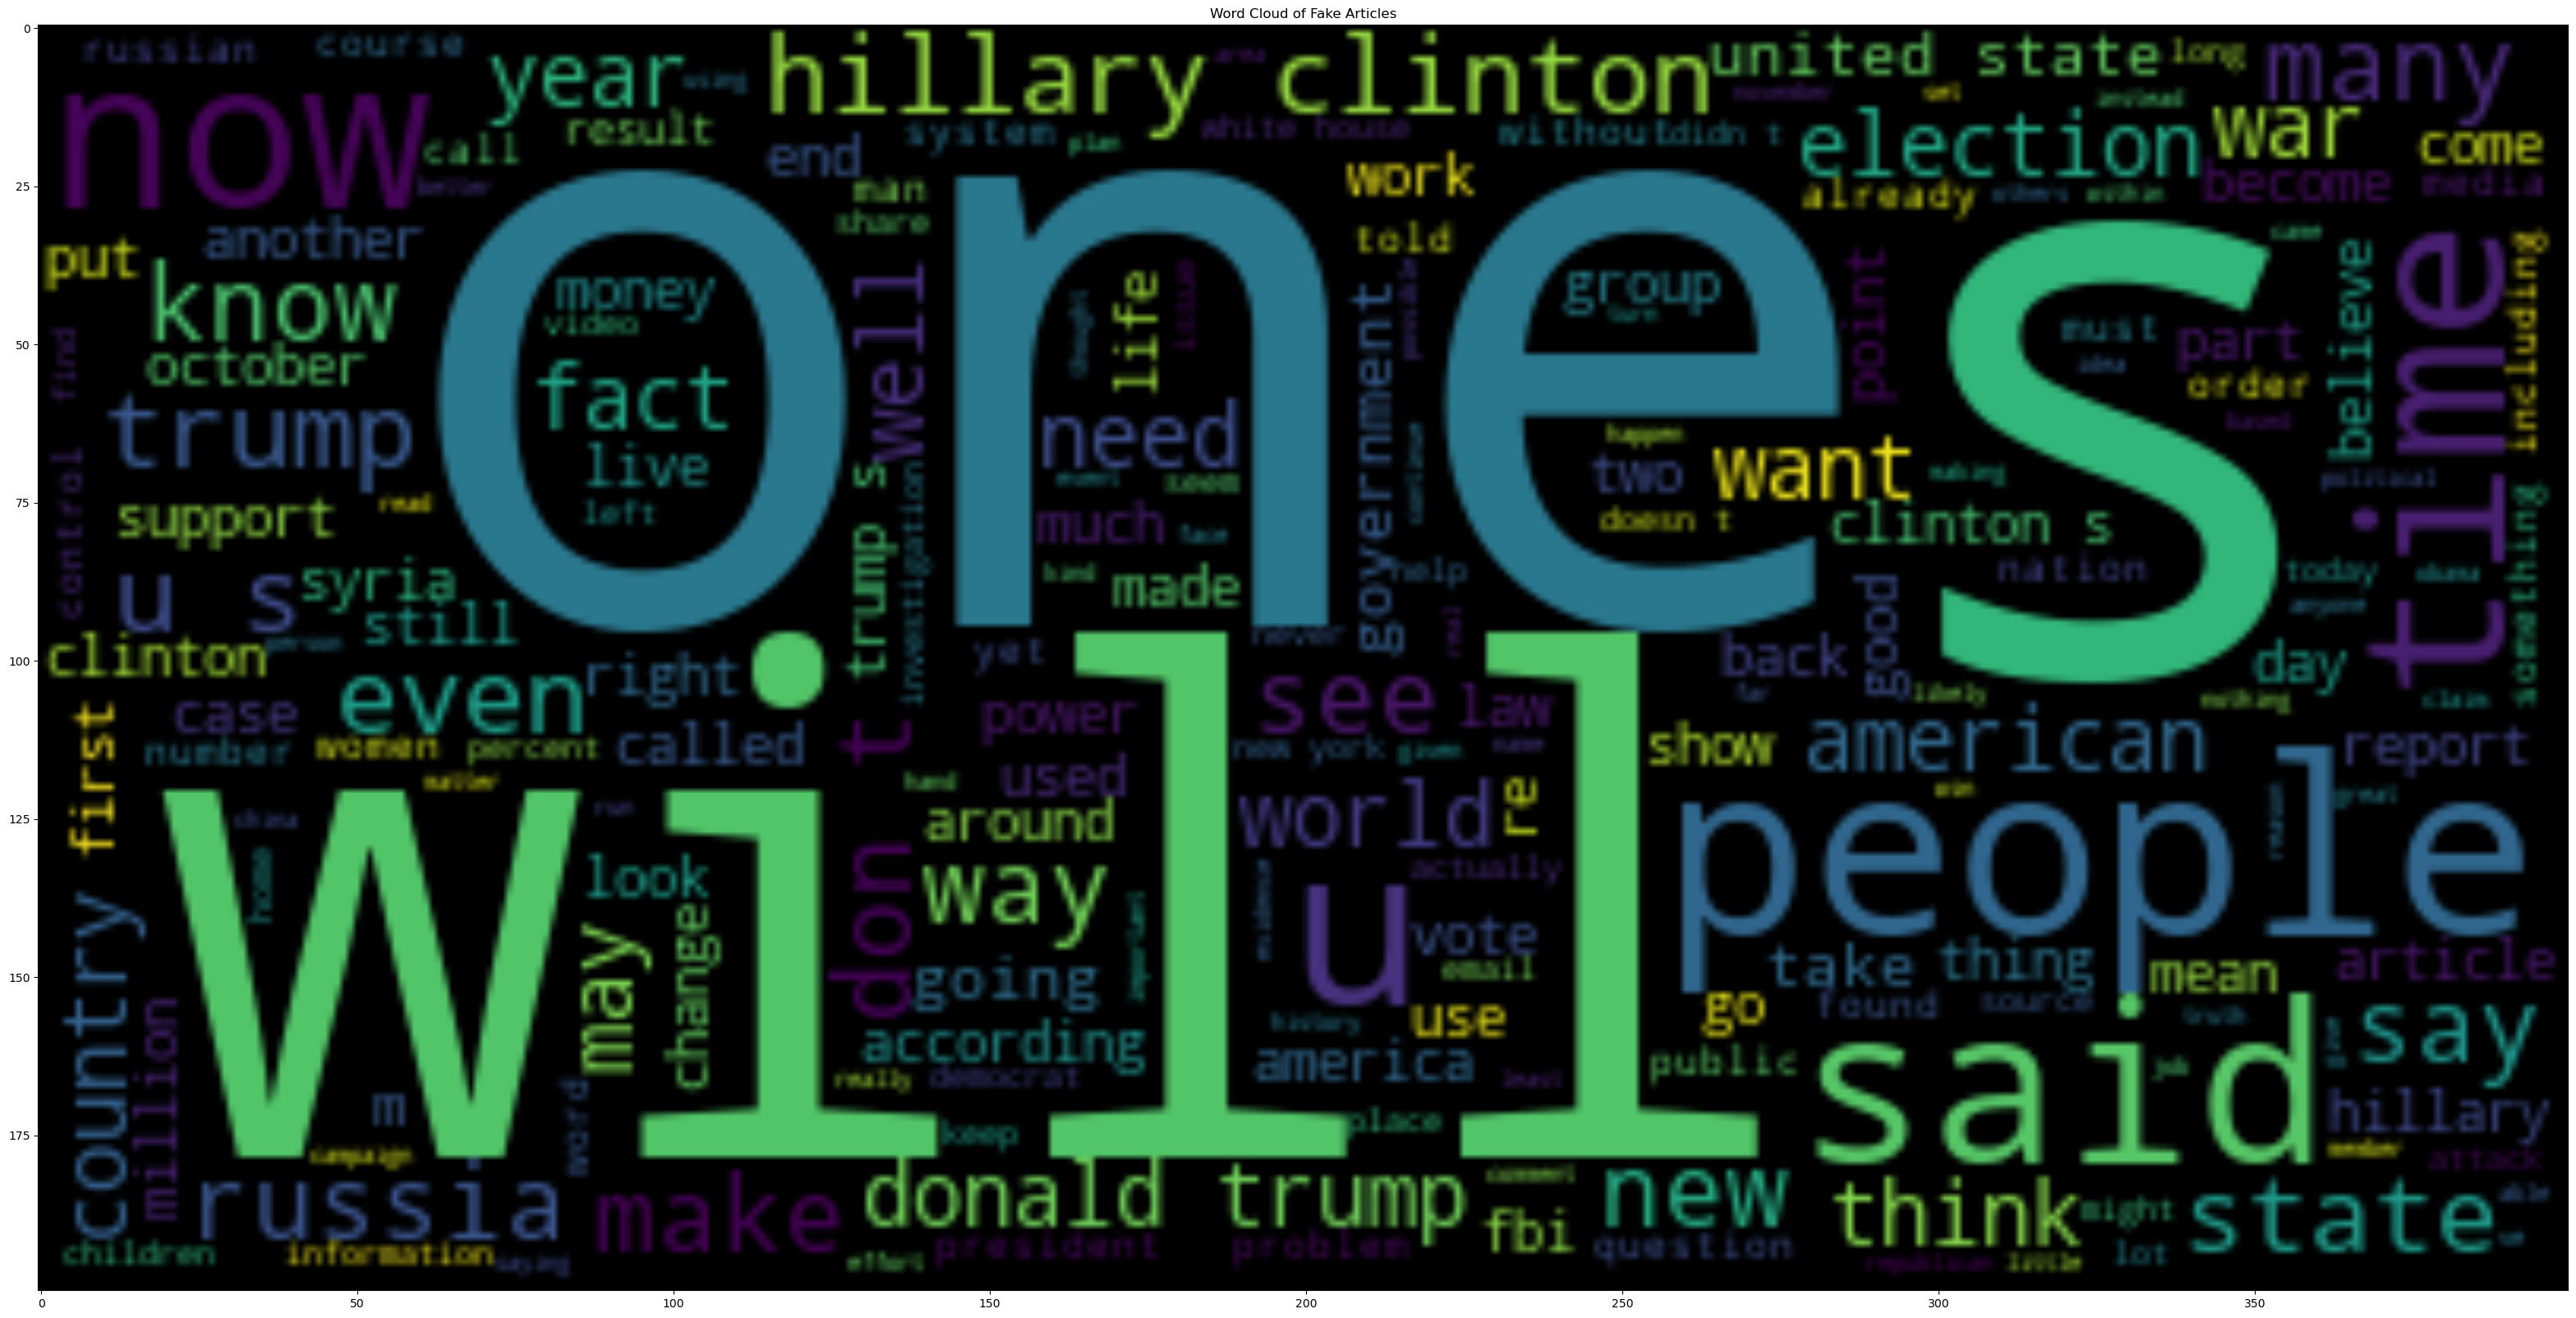

In [10]:
fake_wc = WordCloud().generate(fake_text)
plt.figure(figsize=(40, 20))
plt.tight_layout(pad=0)
plt.imshow(fake_wc, interpolation='bilinear')
plt.title("Word Cloud of Fake Articles")
plt.show()

## Model Training 

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

X = train_clean.text
y = train_clean.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)


In [12]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

start = timer()

params_tfidf = {"n_estimators": [10, 50, 100, 150],
                "max_depth": [6, 7, 8, 9, 10, 25]
               }

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

gs_tfidf = GridSearchCV(LGBMClassifier(random_state=42), param_grid=params_tfidf, cv=5, scoring=scoring, refit="accuracy")


pipe_tfidf = Pipeline([("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1, 1))),
                       ("svd", TruncatedSVD(random_state=42, n_components=1000)),
                       ("gs_lgbm", gs_tfidf)]
                     )

pipe_tfidf.fit(X_train, y_train)

end = timer()
print(f"Time elapsed: {timedelta(seconds=end-start)}")

Time elapsed: 0:10:56.830642


In [13]:
gs_tfidf.cv_results_

{'mean_fit_time': array([1.16391768, 2.51541557, 4.19604173, 5.81339345, 1.23273339,
        2.80900302, 4.74660211, 6.65173335, 1.28358917, 3.00714765,
        5.11459656, 7.42256308, 1.31040297, 3.14117413, 5.36276007,
        7.5829011 , 1.33634305, 3.17847309, 5.43911777, 7.73641281,
        1.70281711, 4.06516666, 6.79247737, 8.56256962]),
 'std_fit_time': array([0.02150292, 0.04871642, 0.02869512, 0.02889782, 0.0157885 ,
        0.03553999, 0.03738461, 0.05456727, 0.01677744, 0.04221586,
        0.06010633, 0.15538714, 0.01410926, 0.0655385 , 0.03771809,
        0.07637141, 0.04559661, 0.0319479 , 0.01033031, 0.05396837,
        0.29171588, 0.39164405, 0.11954998, 0.1455692 ]),
 'mean_score_time': array([0.01499963, 0.01640072, 0.01799836, 0.0210012 , 0.01440182,
        0.01680269, 0.01999989, 0.02360277, 0.01419859, 0.01619878,
        0.02120018, 0.02539639, 0.01359859, 0.01640258, 0.01959772,
        0.02560382, 0.01540108, 0.01739817, 0.02160053, 0.02580047,
        0.017200

In [14]:
fitted_steps = pipe_tfidf.named_steps
fitted_steps.svd.explained_variance_ratio_.sum() # a little low

0.452285421061642

In [17]:
pickle.dump(fitted_steps["tfidf"], open(output_path + "tfidf_vectorizer.pkl", "wb"))
pickle.dump(fitted_steps["svd"], open(output_path + "svd.pkl", "wb"))
pickle.dump(fitted_steps["gs_lgbm"].best_estimator_, open(output_path + "lgbm_with_tfidf.pkl", "wb"))

PermissionError: [Errno 13] Permission denied: './models/svd.pkl'

In [19]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

start = timer()

model = SentenceTransformer("sentence-transformers/paraphrase-albert-small-v2")
pickle.dump(model, open(output_path + "sent_transformer.pkl", "wb"))
# so I can stick encoder into a pipeline
sent_embedding_transformer = FunctionTransformer(lambda text: model.encode(text.tolist()))

params_bert = {"n_estimators": [10, 50, 100, 150],
               "max_depth":  [6, 7, 8, 9, 10, 25]
              }

gs_bert = GridSearchCV(LGBMClassifier(random_state=42), params_bert, cv=5, scoring=scoring, refit="accuracy")

pipe_bert = Pipeline([("embedder", sent_embedding_transformer), ("gs_lgbm", gs_bert)])

pipe_bert.fit(X_train, y_train)

end = timer()
print(f"Time elapsed: {timedelta(seconds=end-start)}")

Time elapsed: 0:35:29.633978


In [20]:
pipe_bert.named_steps["gs_lgbm"].cv_results_

{'mean_fit_time': array([1.38197393, 2.78923359, 4.41731501, 6.04321499, 1.41718221,
        3.13289104, 5.06666479, 7.07285042, 1.41236291, 3.35839977,
        5.62575297, 7.5025115 , 1.45395417, 3.37401118, 5.61570091,
        7.87554879, 1.43424702, 3.45948515, 5.80963068, 8.0094162 ,
        1.48179111, 3.47034459, 5.9520308 , 8.41041045]),
 'std_fit_time': array([0.08192001, 0.0769498 , 0.11414365, 0.12160465, 0.06915625,
        0.10022977, 0.10430288, 0.29886544, 0.04988153, 0.0914919 ,
        0.28614489, 0.1312922 , 0.06956608, 0.06900499, 0.11271331,
        0.13410281, 0.06720374, 0.1012593 , 0.10436938, 0.16101689,
        0.04599318, 0.09151747, 0.08030845, 0.09768086]),
 'mean_score_time': array([0.01960101, 0.02020698, 0.02530746, 0.02839899, 0.01819925,
        0.02170386, 0.02519879, 0.02800941, 0.01740041, 0.02260065,
        0.02652197, 0.03161197, 0.01739974, 0.02179985, 0.02570796,
        0.02980213, 0.01870394, 0.02289891, 0.02700586, 0.0297996 ,
        0.018199

In [ ]:
# dumping embedded text as well just to save time in the future
X_train_embeddings = model.encode(X_train.tolist())
X_test_embeddings = model.encode(X_test.tolist())

pickle.dump(X_train_embeddings, open(output_path+"X_train_embeddings.pkl", "wb"))
pickle.dump(X_test_embeddings, open(output_path+"X_test_embeddings.pkl", "wb"))
pickle.dump(model.encode(train_clean.text.tolist()), open(output_path + "train_sent_embeddings.pkl", "wb"))

In [23]:
pickle.dump(pipe_bert.named_steps["gs_lgbm"].best_estimator_, open(output_path + "lgbm_with_bert.pkl", "wb"))

## Model Comparison and Selection

If I already have above things trained, I can just load them as in below (and **don't** fit, just transform):

In [24]:
tfidf = pickle.load(open(output_path + "tfidf_vectorizer.pkl", "rb"))
svd = pickle.load(open(output_path + "svd.pkl", "rb"))
lgbm_with_tfidf = pickle.load(open(output_path + "lgbm_with_tfidf.pkl", "rb"))

pipe_tfidf = Pipeline([("tfidf", tfidf), ("svd", svd), ("lgbm", lgbm_with_tfidf)])


In [25]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import FunctionTransformer

# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

sent_embedder = FunctionTransformer(lambda text: model.encode(text.tolist()))

lgbm_with_bert = pickle.load(open(output_path + "lgbm_with_bert.pkl", "rb"))

pipe_bert = Pipeline([("embeddings", sent_embedding_transformer), ("lgbm", lgbm_with_bert)])

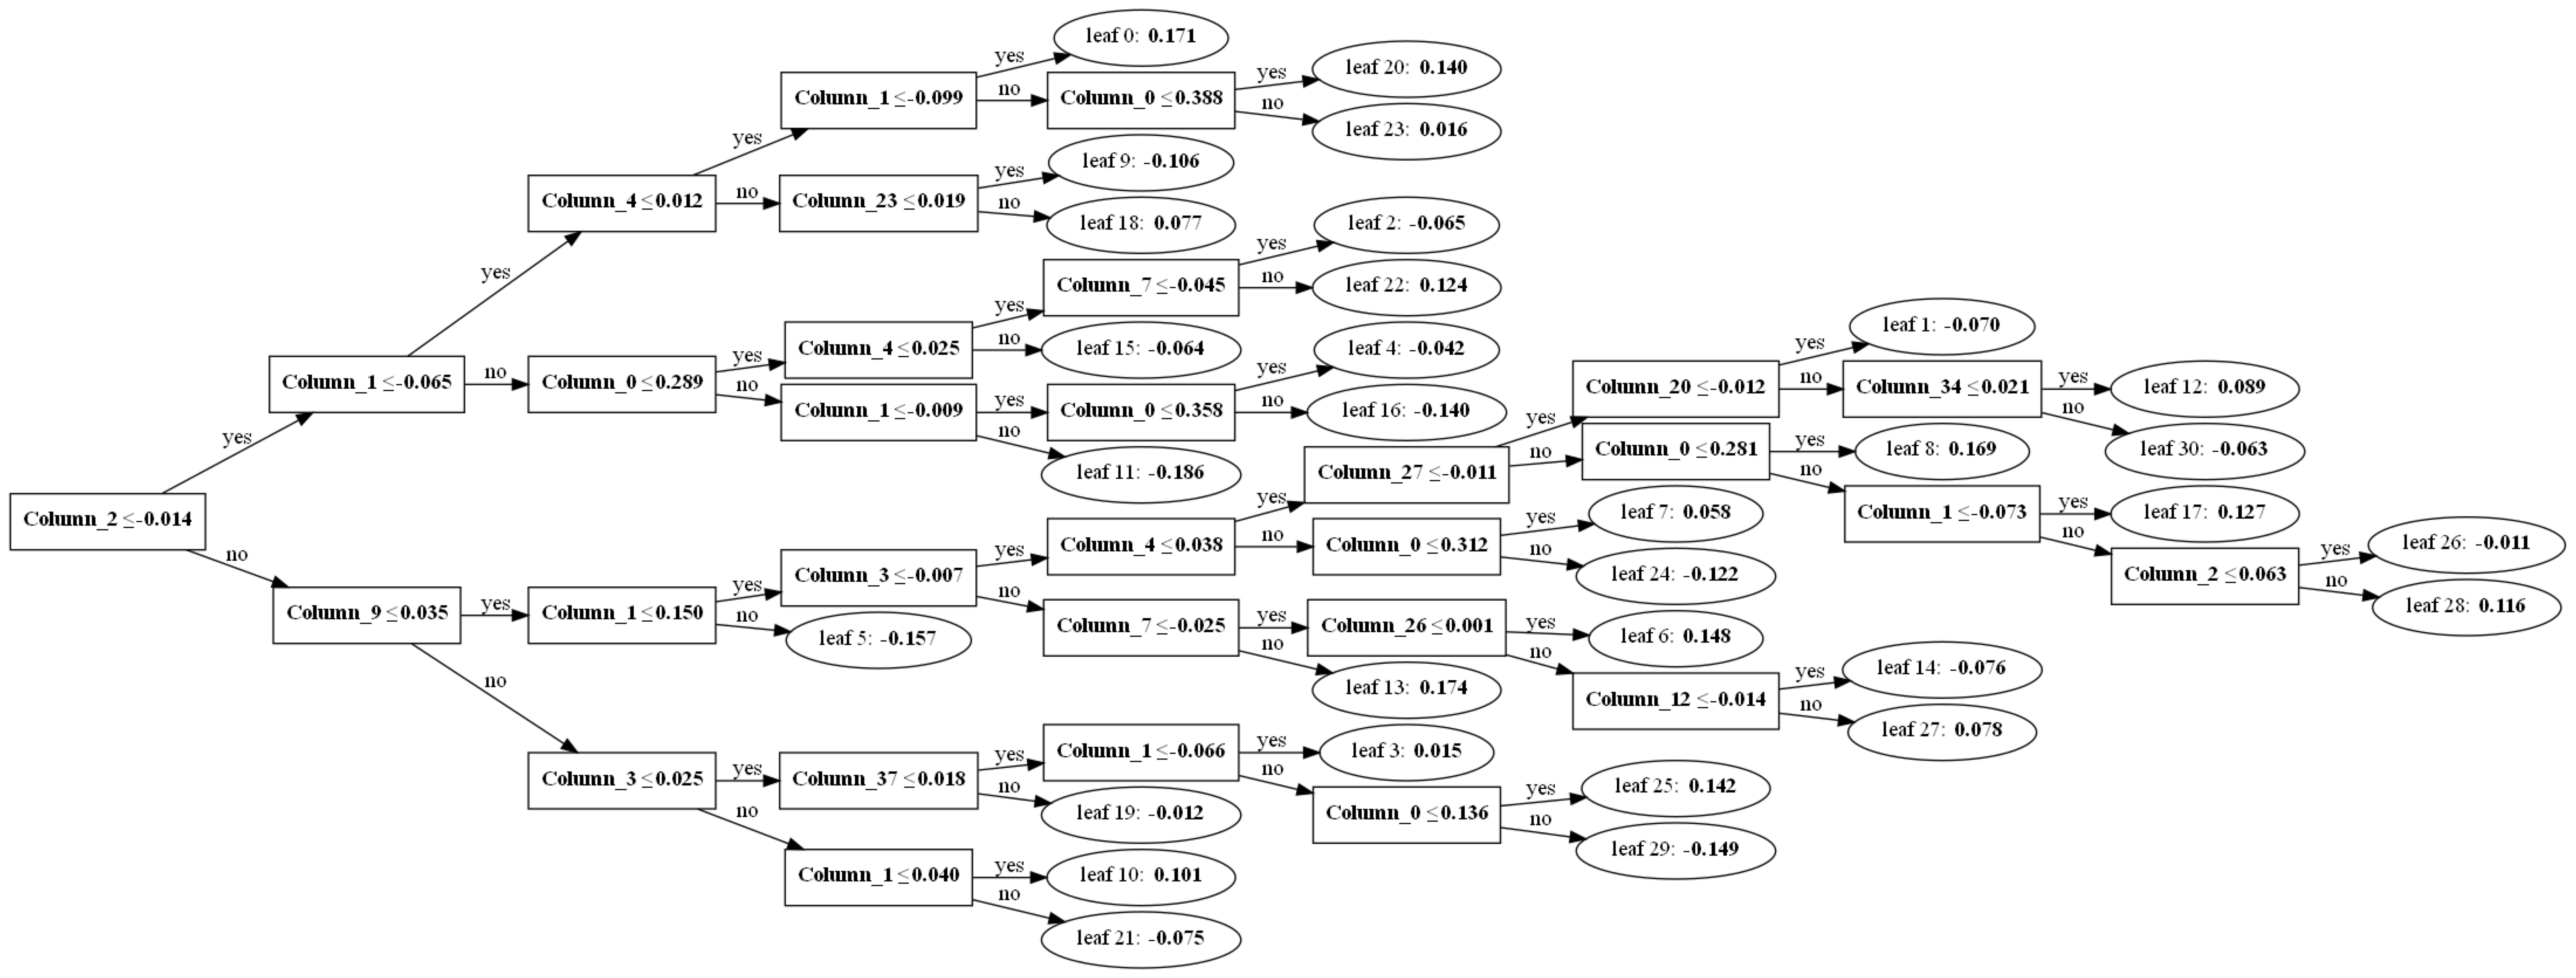

In [26]:
# a bit too small to see, but this is what the first tree looks like; also, here the features are the principle components
##set up the parameters
rcParams['figure.figsize'] = 80,50
from lightgbm import plot_tree

plot_tree(lgbm_with_tfidf)
plt.show()

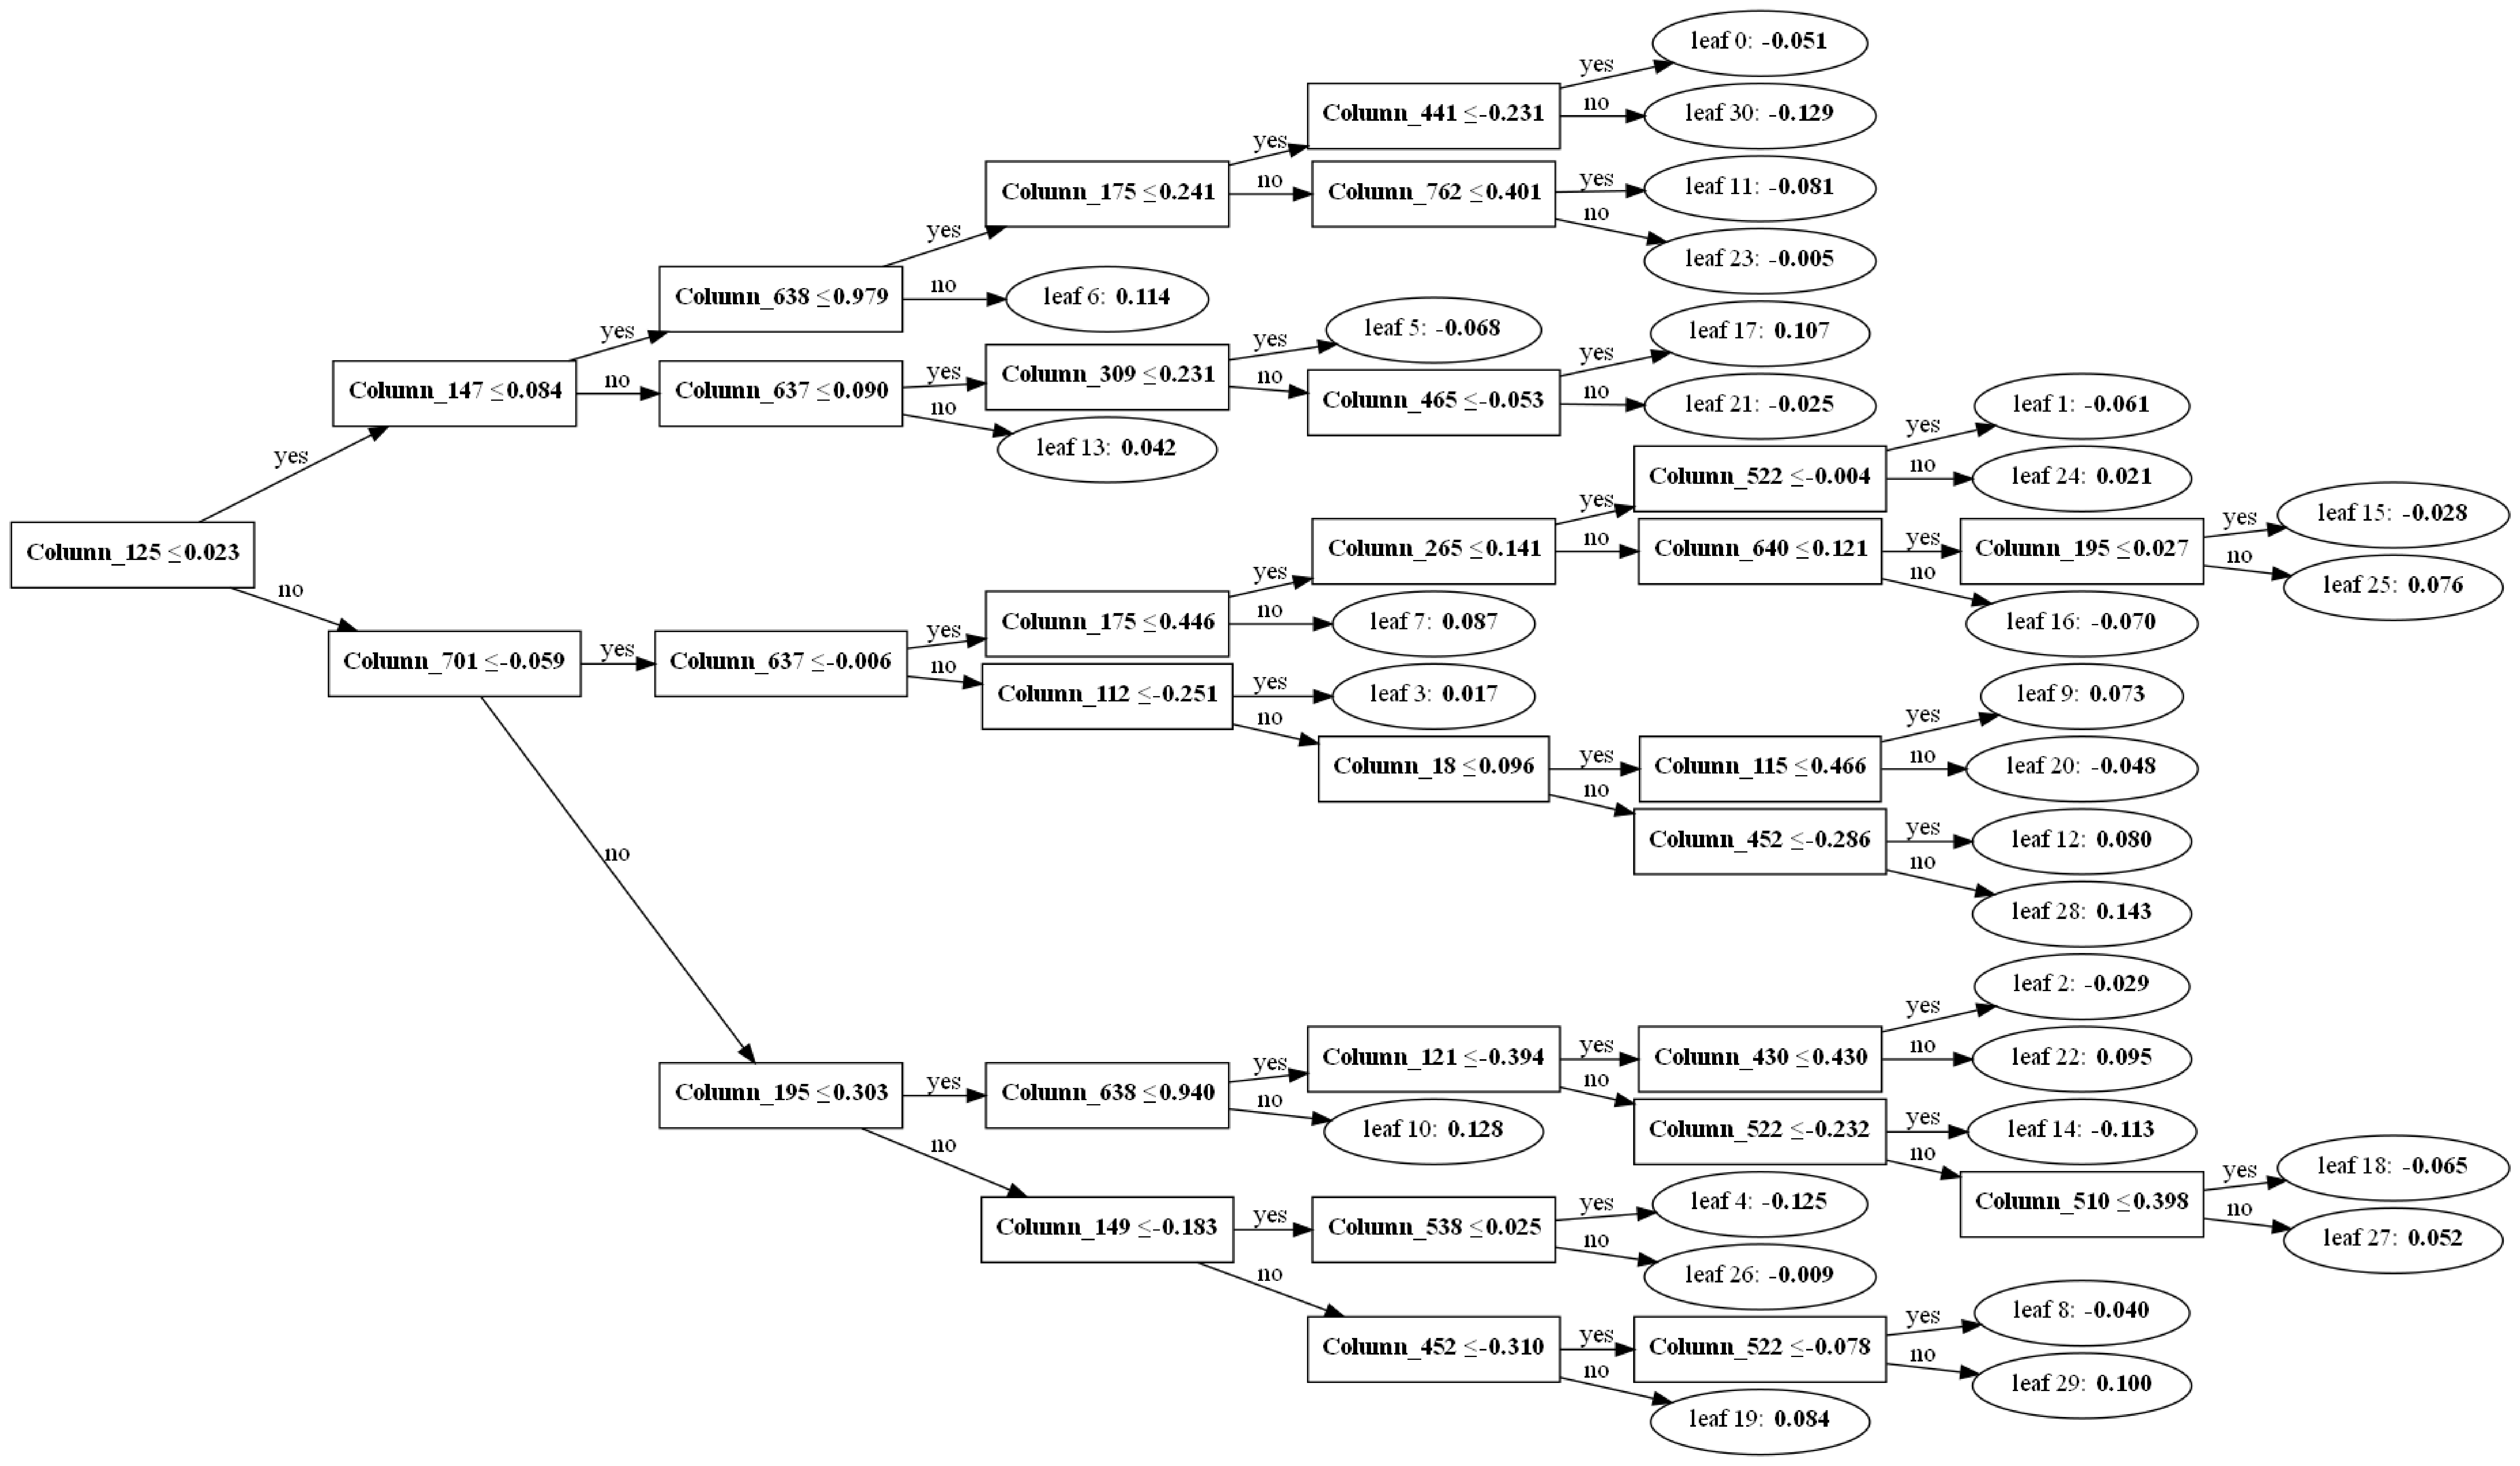

In [27]:
plot_tree(lgbm_with_bert)
plt.show()

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report

def get_scores(model, X_test, y_test):
    """ Calculate fitted binary classifcation model performance with respect to various metrics.
    
    Helper function for sklearn.metrics.classification_report for convenience. Calculate fitted
    binary classification model's Accuracy, Precision, Recall, F-1 score, and Support for both 
    classes in input data.
    
    Args:
        model (sklearn.base.ClassifierMixin) : Fitted classifier that implements scikit-learn API. 
        X_test (array-like) : Data to produce predicted labels.
        y_test (1d array-like) : Correct target values to compare with predicted labels. Label
        values assumed to be 0 and 1, with 0 meaning "Real" and 1 meaning "Fake". Class 1 is the
        "positive" class.
        
    Returns:
        (dict) : Dictionary of score results.
    """

    y_pred = model.predict(X_test)
    metrics = classification_report(y_test, y_pred, labels=[0, 1], target_names=["Real", "Fake"],
                                    digits=4, output_dict=True)
    return metrics
    

In [29]:
results_tfidf = get_scores(pipe_tfidf, X_test, y_test)
# going to load already embedded test set for speed
X_test_embeddings = pickle.load(open(output_path+"X_test_embeddings.pkl", "rb"))
results_bert = get_scores(pipe_bert.named_steps["lgbm"], X_test_embeddings, y_test)
print(pd.DataFrame(results_tfidf))
print(pd.DataFrame(results_bert))

                  Real         Fake  accuracy    macro avg  weighted avg
precision     0.916471     0.938180  0.927041     0.927326      0.927318
recall        0.939846     0.914217  0.927041     0.927031      0.927041
f1-score      0.928011     0.926043  0.927041     0.927027      0.927028
support    2078.000000  2075.000000  0.927041  4153.000000   4153.000000
                  Real         Fake  accuracy    macro avg  weighted avg
precision     0.794720     0.830266  0.811462     0.812493      0.812480
recall        0.840231     0.782651  0.811462     0.811441      0.811462
f1-score      0.816842     0.805755  0.811462     0.811299      0.811303
support    2078.000000  2075.000000  0.811462  4153.000000   4153.000000


# For BERT

### This section is from when I was trying to use BERT for word embeddings, but it was too computationally expensive a task, and sentence embeddings might be better for a use case. Basically this is scratch work that can be ignored

Basically, a "sentence" is just a linguistic body of words, so I'm going to treat each article as a single sentence, because otherwise I'd have to draw a manual distinction between which half of the article is the first "sentence" and which is second.

Max token amount allowed is 512, I'll have to truncate to first few hundred words, but need leeway for words that aren't recognized so they're broken down into multiple subwords. For instance, I first tried truncating to first 500, but I ended up with 535 tokens.

Following along with this: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#1-loading-pre-trained-bert

**TODO:**
* want to play around with xgboost's xgb.train and DMatrix's because the XGBClassifier I'm using is just the sklearn wrapper
* Try to make submission csv's using both sets of models

* Taha has a few other suggestions
    * transformers, specifically huggingface -> just pass data through, and it'll produce embeddings
    * a bit about embeddings
        * formed with artificual neural networks
        * remove output layer, add two inner layers: an encoder and then decoder, they're both fully connected
        * usually input layer isn't fully connected to first encoder inner layer, 
        * output is n-dimensional where n is how many nodes in decoder layer
        * maybe truncate to first 500 words before doing this
    * can use pre-trained models like BERT, gp3 something by Deepmind
    * use examples here: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens, and https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
    * consider also using sentence-level instead of word-level
    * he's also mentioning topioc modeling
        * bunch of text, want to extract groups of topics in corpus
            * use this: https://github.com/MaartenGr/BERTopic

* end product could be like a SaaS application where someone can input a news article and predict whether article is fake news
* streamlit or plotly or flask for frontend
    * in flask, create a file as a server
* for a freecodecamp flask tutorial: https://www.youtube.com/watch?v=Z1RJmh_OqeA
    * but only consider that stuff after I get basic model online